# 文章ベクトルを入力に、DLで分類

### 必要なライブラリをインポート

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as kb

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from gensim import matutils
from gensim import corpora
import pickle
import sys
import glob
sys.path.append('../')
from util import util


### 定数宣言

In [8]:
ROOT_DIR = '.'
DATA_PATH = '/text'
FALSE_DATA_PATH = '/false'
DICTIONARY_PATH = '/Dictionary'
DICTIONARY_NAME = '/dictionary.txt'
WORD_LIST = '/*.word_list'

### ベクトルを１次元配列に変換するメソッド定義

In [9]:
def vec2dense(vec, num_terms):
    return list(matutils.corpus2dense([vec], num_terms=num_terms).T[0])

### モデル構築関数

In [33]:
def build_model(inputShape):
    #ネットワークの構造を定義
    model = Sequential()
    
    # Affine層の追加(units=出力の数, input_shapeは最初の層だけ指定)
    model.add(Dense(units=100, input_shape=(inputShape,))) #input_shapeは入力値の大きさに合わせる
    #model.add(Activation('sigmoid'))
    #model.add(Dense(100))
    
    # Affine層の次は必ずActivation層
    model.add(Activation('relu'))
    
    # またAffine層(
    model.add(Dense(units=9))
    
    # Activation層前にDropout挟むのもあり
    #model.add(Dropout(0.2));
    
    
    model.add(Activation('softmax'))
    return model


### 学習結果の表示関数

In [4]:
def plot_history(history):

    plt.subplot(2,1,1)
    plt.plot(history.history['acc'], "o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    
    plt.subplot(2,1,2)
    plt.plot(history.history['loss'],"o-",label="loss")
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    
    plt.show()

## ここからメイン関数

### データ取得

In [10]:
word_list = []
for path in glob.glob(ROOT_DIR+ROOT_DIR+DATA_PATH+"/*"+WORD_LIST, recursive=True):
    with open(path, "rb") as f:
        words = pickle.load(f)
        word_list.append({'label': path.split("/")[-2], 'words': words})
        
print(len(word_list))
print(word_list[0]['label'], word_list[0]['words'][0])

9
movie-enter {'text': ['ジョニデ', 'バートン', '監督', '贈る', 'ファミリー', 'インパクト', '大', 'キャラクター', 'ビジュアル', '注目', 'バートン', '監督', 'デップ', '最強', 'コンビ', '贈る', '世界', '待望', '大作', '5', '月', '19', '日', '公開', 'キャラクタービジュアル', '公開', 'する', 'れる', '公開', '記念', 'する', 'コスプレコンテスト', '実施', '決定', 'する', '本', '作', '魔女', 'ヴァンパイア', 'する', 'れる', 'しまう', 'バーナバス・コリンズ', '物語', 'ヴァンパイア', 'なる', 'バーナバス', '生き埋め', 'する', 'れる', 'しまう', '目覚める', 'の', '2', '世紀', '後', '1972', '年', '没落', 'する', '家', '末裔', '出会う', 'バーナバス', '父親', '唯一', '財産', '家族', '言葉', '胸', '魔女', '手', '家族', '守る', '一族', '繁栄', '取り戻す', 'する', '1966', '年', '1971', '年', 'ABC', 'テレビ', '放送', 'する', 'れる', '人気', 'ドラマ', 'ベース', '映画', '化', 'する', '作品', '主人公', '1752', '年', '移民', 'する', '裕福', '家', '育つ', 'プレイボーイ', 'バーナバス・コリンズ', '日', '彼', '魔女', 'アンジェリーク', '死', '運命', 'なる', 'ヴァンパイア', 'する', 'れる', '生き埋め', 'する', 'れる', 'しまう', '2', '世紀', '後', '1972', '年', '予期', 'する', 'きっかけ', '自分', '墓', '開放', 'する', 'れる', '劇的', '変化', '遂げる', '世の中', 'バーナバス', '不可思議', '謎', '秘める', '家', '末裔', '姿', '描く', '父親', '唯一', '財産', '家族', '言葉',

### 各フォルダのファイル数を確認

In [11]:
for words in word_list:
    print(len(words['words']))

870
870
864
770
511
843
900
870
870


### word_listをラベル、文書、ファイル名に分ける

In [12]:
label = util.get_path_list(ROOT_DIR+ROOT_DIR+DATA_PATH)
for words in word_list:
    label_array = []
    for word in words['words']:
        label_array.append(label.index(words['label']))
    words['labels'] = label_array
    print(words['label'], words['labels'])

movie-enter [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 保存してた辞書を読み込む
warning出るけど、古いよってやつだからとりあえずシカト（でも毎回出るのはウザいな）

In [13]:
dictionary = corpora.Dictionary.load_from_text(ROOT_DIR+ROOT_DIR+DICTIONARY_PATH+DICTIONARY_NAME)

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 辞書の大きさの１次元配列を文章毎に作成する
http://kento1109.hatenablog.com/entry/2017/11/15/230909 \
https://qiita.com/hyo_07/items/ba3d53868b2f55ed9941
       

In [14]:
for words in word_list:
    for word in words['words']:
        word['text'] = vec2dense(dictionary.doc2bow(word['text']), len(dictionary))

### １つの文章が以下のようなベクトルになる
頻出度をベクトルにした感じかな。まぁBoWだからそうか。\
TF-IDFをベクトルにしたものの方が割りかしいいかも\
後、頻出しないものは0って固定されてるのもいいのかな？＝＞単純に0がいいのか不明。少なくともword2vecのベクトルだとこれとは違うがマイナスとかの概念があって、それによって距離感とか上手く表現出来てる？（作成者も多分わかってない笑）
下記の標準化とは違うと思う

In [15]:
print(word_list[0]['words'][0])

{'text': [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 5.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 5.0, 4.0, 1.0, 7.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 3.0, 1.0, 4.0, 2.0, 1.0, 7.0, 1.0, 5.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

### データを分ける
test_size ・・・　割り合い決める0.1か0.2がいいかな\
random_state　・・・　データ分割のランダム化を制御する値。詳しくは不明だが、これをNoneにするとランダムになり、実行の度にデータが変化する。（割合はtest_sizeに準ずる）つまりは分割する場所がランダムになる。\
shuffle　・・・　データをシャッフルするか\
返り値は名前の通り


今回はラベル毎に9:1の割合で分ける。これによりラベル毎の偏りをなくす

In [55]:
X_train = []
X_test = []
y_train = []
y_test = []

for words in word_list:
    x_tr, x_te, y_tr, y_te = train_test_split(words['words'], words['labels'], test_size=0.1, random_state=1, shuffle=True)
    X_train.extend(x_tr)
    X_test.extend(x_te)
    y_train.extend(y_tr)
    y_test.extend(y_te)

print('X_train',len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

X_train 6629
X_test 739
y_train 6629
y_test 739


### データを1次元配列に戻す

In [56]:
train_file_name = [data['file'] for data in X_train]
X_train = [data['text'] for data in X_train]
test_file_name = [data['file'] for data in X_test]
X_test = [data['text'] for data in X_test]

### 正解データをone-hotベクトル化する

In [57]:
print(y_train[0])
y_train = np_utils.to_categorical(y_train, len(label))
y_test = np_utils.to_categorical(y_test, len(label))

0


In [58]:
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]


### データ標準化
色々説明必要だけど長いから参照: http://ailaby.com/scaler/ \
ここでのfitは学習ではなく、平均0,分散1にしてるみたいです。\
参照: http://learning.ikeay.net/entry/2016/07/19/140930

In [59]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [60]:
print(X_train_std[0])

[-0.27278564 -0.22419041 -0.2025877  ... -0.26826483 -0.19672977
 -0.13050343]


### ハイパーパラメータ設定

In [97]:
# 学習データを分ける単位
batch_size = 128

# 学習回数
epoch = 1000

# 学習率
learning_rate = 0.01

# 学習遅延
decay = 0.0

# 学習の滑らかさ
momentum = 0.0

# 学習最適化手法
nesterov=False

### ニューラルネットワーク構築

In [98]:
# 多層ニューラルネットワークモデルを構築
model = build_model(len(X_train[0]))
print("入力層:",len(X_train[0]))

入力層: 1160


### ニューラルネットワークのサマリ

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               116100    
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 909       
_________________________________________________________________
activation_22 (Activation)   (None, 9)                 0         
Total params: 117,009
Trainable params: 117,009
Non-trainable params: 0
_________________________________________________________________


### 学習最適化アルゴリズムの選択

In [100]:
sgd = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=nesterov)

### モデルのコンパイル(loss=損失関数,optimizer=学習最適化アルゴリズム(上で定義した変数))

In [101]:
model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

In [102]:
print(type(X_train[0][0]))

<class 'numpy.float32'>


### モデルの訓練

In [103]:
history = model.fit(X_train_std, y_train,
                        batch_size=batch_size,
                        nb_epoch=epoch,
                        verbose=1,
                        validation_data=(X_test_std,y_test))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 6629 samples, validate on 739 samples
Epoch 1/1000
6629/6629 [==============================] - 1s 81us/step - loss: 2.0837 - acc: 0.2916 - val_loss: 1.5544 - val_acc: 0.5196
Epoch 2/1000
6629/6629 [==============================] - 0s 38us/step - loss: 1.3071 - acc: 0.6123 - val_loss: 1.1486 - val_acc: 0.6779
Epoch 3/1000
6629/6629 [==============================] - 0s 42us/step - loss: 0.9846 - acc: 0.7313 - val_loss: 0.9423 - val_acc: 0.7388
Epoch 4/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.8011 - acc: 0.7850 - val_loss: 0.8170 - val_acc: 0.7754
Epoch 5/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.6809 - acc: 0.8190 - val_loss: 0.7337 - val_acc: 0.7970
Epoch 6/1000
6629/6629 [==============================] - 0s 37us/step - loss: 0.5948 - acc: 0.8424 - val_loss: 0.6737 - val_acc: 0.8092
Epoch 7/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.5293 - acc: 0.8621 - val_loss: 0.6281 - val_acc: 0

6629/6629 [==============================] - 0s 37us/step - loss: 0.0580 - acc: 0.9947 - val_loss: 0.3313 - val_acc: 0.8931
Epoch 61/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0566 - acc: 0.9950 - val_loss: 0.3308 - val_acc: 0.8931
Epoch 62/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0554 - acc: 0.9955 - val_loss: 0.3302 - val_acc: 0.8931
Epoch 63/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0541 - acc: 0.9958 - val_loss: 0.3297 - val_acc: 0.8931
Epoch 64/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0529 - acc: 0.9958 - val_loss: 0.3293 - val_acc: 0.8931
Epoch 65/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.0518 - acc: 0.9959 - val_loss: 0.3288 - val_acc: 0.8931
Epoch 66/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0507 - acc: 0.9962 - val_loss: 0.3283 - val_acc: 0.8945
Epoch 67/1000
6629/6629 [=======================

6629/6629 [==============================] - 0s 33us/step - loss: 0.0223 - acc: 0.9988 - val_loss: 0.3201 - val_acc: 0.8958
Epoch 120/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0221 - acc: 0.9988 - val_loss: 0.3201 - val_acc: 0.8958
Epoch 121/1000
6629/6629 [==============================] - 0s 32us/step - loss: 0.0218 - acc: 0.9988 - val_loss: 0.3202 - val_acc: 0.8958
Epoch 122/1000
6629/6629 [==============================] - 0s 32us/step - loss: 0.0216 - acc: 0.9988 - val_loss: 0.3201 - val_acc: 0.8958
Epoch 123/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0214 - acc: 0.9988 - val_loss: 0.3201 - val_acc: 0.8958
Epoch 124/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0211 - acc: 0.9988 - val_loss: 0.3201 - val_acc: 0.8972
Epoch 125/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0209 - acc: 0.9988 - val_loss: 0.3202 - val_acc: 0.8972
Epoch 126/1000
6629/6629 [================

6629/6629 [==============================] - 0s 55us/step - loss: 0.0132 - acc: 0.9991 - val_loss: 0.3221 - val_acc: 0.8985
Epoch 179/1000
6629/6629 [==============================] - 0s 62us/step - loss: 0.0131 - acc: 0.9991 - val_loss: 0.3221 - val_acc: 0.8985
Epoch 180/1000
6629/6629 [==============================] - 0s 52us/step - loss: 0.0130 - acc: 0.9991 - val_loss: 0.3222 - val_acc: 0.8985
Epoch 181/1000
6629/6629 [==============================] - 0s 61us/step - loss: 0.0129 - acc: 0.9991 - val_loss: 0.3222 - val_acc: 0.8985
Epoch 182/1000
6629/6629 [==============================] - 0s 54us/step - loss: 0.0128 - acc: 0.9991 - val_loss: 0.3223 - val_acc: 0.8985
Epoch 183/1000
6629/6629 [==============================] - 0s 52us/step - loss: 0.0128 - acc: 0.9991 - val_loss: 0.3224 - val_acc: 0.8985
Epoch 184/1000
6629/6629 [==============================] - 0s 54us/step - loss: 0.0127 - acc: 0.9991 - val_loss: 0.3224 - val_acc: 0.8985
Epoch 185/1000
6629/6629 [================

6629/6629 [==============================] - 0s 58us/step - loss: 0.0092 - acc: 0.9992 - val_loss: 0.3254 - val_acc: 0.8999
Epoch 238/1000
6629/6629 [==============================] - 0s 43us/step - loss: 0.0092 - acc: 0.9992 - val_loss: 0.3255 - val_acc: 0.8999
Epoch 239/1000
6629/6629 [==============================] - 0s 44us/step - loss: 0.0091 - acc: 0.9994 - val_loss: 0.3255 - val_acc: 0.8999
Epoch 240/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0091 - acc: 0.9992 - val_loss: 0.3256 - val_acc: 0.8999
Epoch 241/1000
6629/6629 [==============================] - 0s 40us/step - loss: 0.0090 - acc: 0.9994 - val_loss: 0.3257 - val_acc: 0.8999
Epoch 242/1000
6629/6629 [==============================] - 0s 38us/step - loss: 0.0090 - acc: 0.9994 - val_loss: 0.3258 - val_acc: 0.8999
Epoch 243/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0089 - acc: 0.9995 - val_loss: 0.3258 - val_acc: 0.8999
Epoch 244/1000
6629/6629 [================

6629/6629 [==============================] - 0s 38us/step - loss: 0.0070 - acc: 0.9995 - val_loss: 0.3291 - val_acc: 0.8985
Epoch 297/1000
6629/6629 [==============================] - 0s 49us/step - loss: 0.0069 - acc: 0.9995 - val_loss: 0.3291 - val_acc: 0.8985
Epoch 298/1000
6629/6629 [==============================] - 0s 48us/step - loss: 0.0069 - acc: 0.9995 - val_loss: 0.3292 - val_acc: 0.8985
Epoch 299/1000
6629/6629 [==============================] - 0s 40us/step - loss: 0.0069 - acc: 0.9995 - val_loss: 0.3292 - val_acc: 0.8985
Epoch 300/1000
6629/6629 [==============================] - 0s 45us/step - loss: 0.0069 - acc: 0.9995 - val_loss: 0.3293 - val_acc: 0.8985
Epoch 301/1000
6629/6629 [==============================] - 0s 38us/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.3294 - val_acc: 0.8985
Epoch 302/1000
6629/6629 [==============================] - 0s 45us/step - loss: 0.0068 - acc: 0.9995 - val_loss: 0.3294 - val_acc: 0.8985
Epoch 303/1000
6629/6629 [================

6629/6629 [==============================] - 0s 46us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.3326 - val_acc: 0.8985
Epoch 356/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.3326 - val_acc: 0.8985
Epoch 357/1000
6629/6629 [==============================] - 0s 38us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.3327 - val_acc: 0.8985
Epoch 358/1000
6629/6629 [==============================] - 0s 42us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.3328 - val_acc: 0.8985
Epoch 359/1000
6629/6629 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.3328 - val_acc: 0.8985
Epoch 360/1000
6629/6629 [==============================] - 0s 48us/step - loss: 0.0054 - acc: 0.9998 - val_loss: 0.3329 - val_acc: 0.8985
Epoch 361/1000
6629/6629 [==============================] - 0s 44us/step - loss: 0.0054 - acc: 0.9998 - val_loss: 0.3329 - val_acc: 0.8985
Epoch 362/1000
6629/6629 [================

6629/6629 [==============================] - 0s 36us/step - loss: 0.0046 - acc: 0.9998 - val_loss: 0.3359 - val_acc: 0.8999
Epoch 415/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3360 - val_acc: 0.8999
Epoch 416/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3360 - val_acc: 0.8999
Epoch 417/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3361 - val_acc: 0.8999
Epoch 418/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3361 - val_acc: 0.8999
Epoch 419/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3362 - val_acc: 0.8999
Epoch 420/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.3362 - val_acc: 0.8999
Epoch 421/1000
6629/6629 [================

6629/6629 [==============================] - 0s 36us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.3389 - val_acc: 0.9026
Epoch 474/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3390 - val_acc: 0.9026
Epoch 475/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3390 - val_acc: 0.9026
Epoch 476/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3391 - val_acc: 0.9026
Epoch 477/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3391 - val_acc: 0.9026
Epoch 478/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3392 - val_acc: 0.9026
Epoch 479/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3392 - val_acc: 0.9026
Epoch 480/1000
6629/6629 [================

6629/6629 [==============================] - 0s 36us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3417 - val_acc: 0.9026
Epoch 533/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3417 - val_acc: 0.9026
Epoch 534/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.9026
Epoch 535/1000
6629/6629 [==============================] - 0s 37us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3418 - val_acc: 0.9026
Epoch 536/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3419 - val_acc: 0.9026
Epoch 537/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3419 - val_acc: 0.9026
Epoch 538/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3420 - val_acc: 0.9026
Epoch 539/1000
6629/6629 [================

6629/6629 [==============================] - 0s 35us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3443 - val_acc: 0.9026
Epoch 592/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3443 - val_acc: 0.9026
Epoch 593/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3444 - val_acc: 0.9026
Epoch 594/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3444 - val_acc: 0.9026
Epoch 595/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3445 - val_acc: 0.9026
Epoch 596/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3445 - val_acc: 0.9039
Epoch 597/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3446 - val_acc: 0.9039
Epoch 598/1000
6629/6629 [================

6629/6629 [==============================] - 0s 35us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3467 - val_acc: 0.9026
Epoch 651/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3467 - val_acc: 0.9026
Epoch 652/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3468 - val_acc: 0.9026
Epoch 653/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3468 - val_acc: 0.9026
Epoch 654/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3468 - val_acc: 0.9026
Epoch 655/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3469 - val_acc: 0.9026
Epoch 656/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3469 - val_acc: 0.9026
Epoch 657/1000
6629/6629 [================

6629/6629 [==============================] - 0s 36us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3489 - val_acc: 0.9026
Epoch 710/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9026
Epoch 711/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9026
Epoch 712/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3490 - val_acc: 0.9026
Epoch 713/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3491 - val_acc: 0.9026
Epoch 714/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3491 - val_acc: 0.9026
Epoch 715/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.3491 - val_acc: 0.9026
Epoch 716/1000
6629/6629 [================

6629/6629 [==============================] - 0s 36us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3510 - val_acc: 0.9026
Epoch 769/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3510 - val_acc: 0.9026
Epoch 770/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3511 - val_acc: 0.9026
Epoch 771/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3511 - val_acc: 0.9026
Epoch 772/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9026
Epoch 773/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9026
Epoch 774/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9026
Epoch 775/1000
6629/6629 [================

6629/6629 [==============================] - 0s 50us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3530 - val_acc: 0.9039
Epoch 828/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3530 - val_acc: 0.9039
Epoch 829/1000
6629/6629 [==============================] - 0s 52us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9039
Epoch 830/1000
6629/6629 [==============================] - 0s 48us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9039
Epoch 831/1000
6629/6629 [==============================] - 0s 51us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3531 - val_acc: 0.9039
Epoch 832/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3532 - val_acc: 0.9039
Epoch 833/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3532 - val_acc: 0.9039
Epoch 834/1000
6629/6629 [================

6629/6629 [==============================] - 0s 37us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3548 - val_acc: 0.9039
Epoch 887/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3549 - val_acc: 0.9039
Epoch 888/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3549 - val_acc: 0.9039
Epoch 889/1000
6629/6629 [==============================] - 0s 35us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3549 - val_acc: 0.9039
Epoch 890/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3550 - val_acc: 0.9039
Epoch 891/1000
6629/6629 [==============================] - 0s 33us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3550 - val_acc: 0.9039
Epoch 892/1000
6629/6629 [==============================] - 0s 34us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3550 - val_acc: 0.9039
Epoch 893/1000
6629/6629 [================

6629/6629 [==============================] - 0s 46us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3566 - val_acc: 0.9053
Epoch 946/1000
6629/6629 [==============================] - 0s 40us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.9053
Epoch 947/1000
6629/6629 [==============================] - 0s 45us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.9053
Epoch 948/1000
6629/6629 [==============================] - 0s 36us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.9053
Epoch 949/1000
6629/6629 [==============================] - 0s 40us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.9053
Epoch 950/1000
6629/6629 [==============================] - 0s 45us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3568 - val_acc: 0.9053
Epoch 951/1000
6629/6629 [==============================] - 0s 41us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.3568 - val_acc: 0.9053
Epoch 952/1000
6629/6629 [================

### モデルの評価

In [104]:
loss, acc = model.evaluate(X_test_std, y_test, verbose=0)

print('Test loss:', loss)
print('Test acc:', acc)

Test loss: 0.3581873358773098
Test acc: 0.9066305818673883


### 学習結果表示

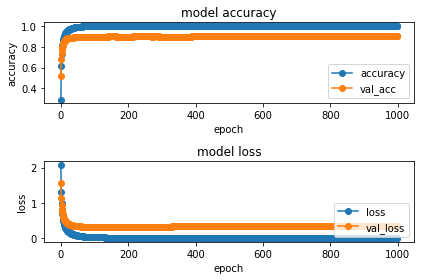

In [105]:
plot_history(history)